# Brain age regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices.csv',index_col=['Institution','Subject','Run'])
phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic.csv',index_col=['Institution','Subject'])

In [3]:
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = ((df.reset_index()).drop(columns=['Institution', 'Subject', 'Run'])).dropna()

## 2. Starting modelling

In [4]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = df.Age

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [9]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
reg.score(X, y)
y_pred = reg.predict(X_test)

TypeError: predict() missing 1 required positional argument: 'X'

In [15]:
y_pred = reg.predict(X_test)

In [16]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

3.617262983668848e-14

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg, X, y, cv=5,scoring='neg_mean_absolute_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-1.87 accuracy with a standard deviation of 0.34


### PCA

In [26]:
from sklearn.decomposition import PCA


# PCA
pca = PCA(n_components=500)
XPCA = pca.fit_transform(X.iloc[:,:])

In [27]:
df_pca = pd.DataFrame(XPCA)
df_pca['Age'] = df.Age
df_pca = df_pca.dropna()

In [28]:
from pycaret.regression import *
s = setup(df_pca, target = 'Age')

,Description,Value
0,session_id,8105
1,Target,Age
2,Original Data,"(2346, 501)"
3,Missing Values,False
4,Numeric Features,500
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1642, 500)"


In [29]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,1.8053,5.5582,2.3549,0.4455,0.1805,0.1600,0.0850
lightgbm,Light Gradient Boosting Machine,1.8203,5.8494,2.4144,0.4201,0.1832,0.1611,1.3940
et,Extra Trees Regressor,1.9408,6.1851,2.4834,0.3868,0.1898,0.1747,2.3620
xgboost,Extreme Gradient Boosting,1.9384,6.5952,2.5650,0.3445,0.1967,0.1733,4.3550
rf,Random Forest Regressor,2.0408,6.7408,2.5937,0.3312,0.1991,0.1844,5.3390
gbr,Gradient Boosting Regressor,2.0361,6.7691,2.5988,0.3283,0.1978,0.1811,4.9530
ridge,Ridge Regression,2.0785,7.4755,2.7262,0.2526,0.2330,0.1899,0.0180
lr,Linear Regression,2.0794,7.4841,2.7277,0.2517,0.2332,0.1900,0.0310
huber,Huber Regressor,2.0797,7.8232,2.7882,0.2176,0.2397,0.1881,0.1610
omp,Orthogonal Matching Pursuit,2.1961,7.9039,2.8063,0.2133,0.2193,0.1953,0.0200


In [30]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [32]:
bayesian_bridge = create_model('br') 
tuned_bayesian_bridge = tune_model(bayesian_bridge)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.7809,5.5175,2.3489,0.4983,0.1778,0.1526
1,1.7664,5.2592,2.2933,0.3993,0.1800,0.1625
2,1.7727,6.1029,2.4704,0.4220,0.1779,0.1468
3,1.7039,5.1506,2.2695,0.4478,0.1740,0.1499
4,1.7306,5.0229,2.2412,0.4537,0.1742,0.1539
5,1.8488,5.5241,2.3503,0.5126,0.1809,0.1651
6,1.9388,6.1886,2.4877,0.3689,0.1856,0.1627
7,2.0229,6.5569,2.5606,0.3546,0.2054,0.1912
8,1.9145,5.5111,2.3476,0.4167,0.1880,0.1787
9,1.5741,4.7472,2.1788,0.5816,0.1614,0.1361


In [33]:
predictions = predict_model(tuned_bayesian_bridge, data=df_pca)
predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,Age,Label
0,-8.920600,-6.193445,3.121200,0.134349,-0.582555,-5.793871,-2.157902,-0.749124,2.835942,4.785680,...,1.414010,-0.809399,0.115859,2.223375,1.441817,1.254023,1.118040,-0.970993,12.36,10.733925
1,-10.879961,-8.079915,-1.207724,4.890428,-3.623022,-6.226001,-1.102698,-1.664399,4.282130,7.631329,...,1.697282,-0.991592,0.464910,2.204569,1.717963,1.845804,1.169544,-1.161579,12.36,10.213723
2,-7.601821,16.942692,-1.064317,-2.700549,1.535688,3.478316,-2.022569,-2.569493,7.043982,5.357063,...,0.472307,-0.456902,-1.372059,-0.067424,-0.171970,-1.285636,1.573938,0.381104,12.98,11.971363
3,-7.020060,15.031782,1.667049,-4.013211,0.697627,1.385573,-2.767164,-2.997155,5.470248,4.712797,...,0.537668,-0.610828,-1.194766,-0.211960,-0.247616,-1.004395,1.139821,0.040678,12.98,12.038632
4,-0.769447,-2.824087,8.465968,-5.084323,8.972757,-2.088689,-5.482464,-4.600495,-1.815022,9.647058,...,0.717664,-1.253503,2.865030,-1.846748,-1.576767,0.561799,2.641056,-1.019194,9.12,10.090891


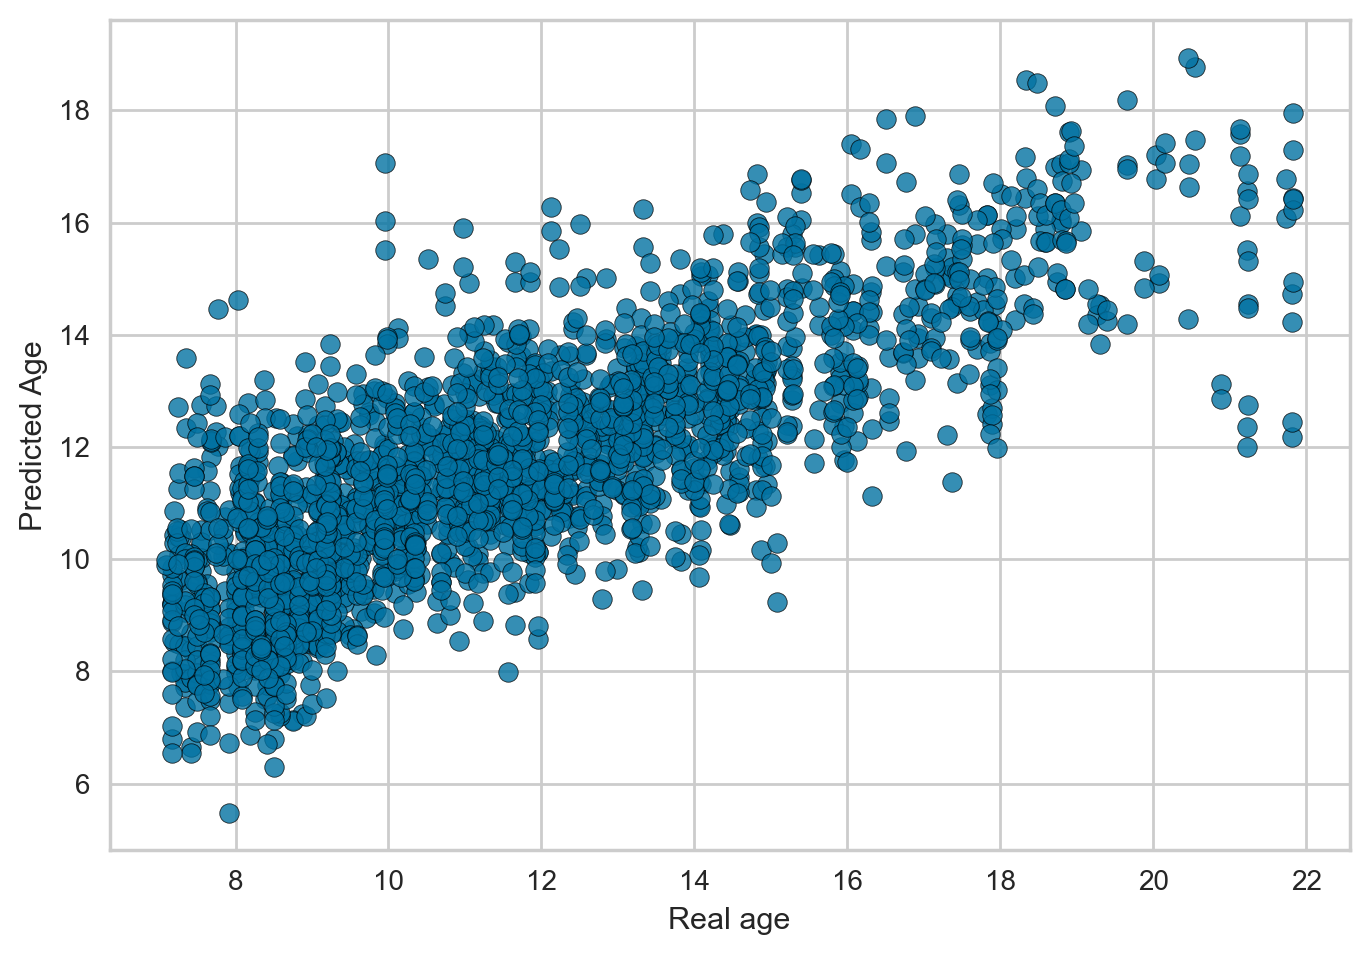

In [45]:
plt.figure(dpi=200)
plt.scatter(predictions.Age,predictions.Label,alpha=0.8, edgecolors='black')
plt.ylabel('Predicted Age')
plt.xlabel('Real age')
plt.show()